# Ejercicio 1: Stencil 1D (CPU vs GPU)

Este notebook implementa la solución al Ejercicio 1 de la práctica.

1.  **Escribe** el programa C++/CUDA en un archivo (`stencil_1d.cu`).
2.  **Compila** el archivo usando `nvcc`.
3.  **Ejecuta** el programa compilado. La salida se imprime y se guarda en `results.txt`.
4.  **Usa Python** (pandas y matplotlib) para leer `results.txt` y generar las gráficas solicitadas.

In [ ]:
%%writefile stencil_1d.cu
#include <iostream>
#include <stdlib.h>
#include <sys/time.h> // Para gettimeofday()
#include <stdio.h>
#include <string.h> // Para memset
#include <cuda_runtime.h> // Para cudaFree, cudaMemcpy, etc.

// --- Constantes ---
// Radio del stencil, como en las diapositivas
#define RADIUS 3
// Hilos por bloque (BLOCK_SIZE)
#define BLOCK_SIZE 256

/**
 * @brief Calcula el tiempo transcurrido en milisegundos.
 */
double get_time_ms(struct timeval start, struct timeval end) {
    return (end.tv_sec - start.tv_sec) * 1000.0 + (end.tv_usec - start.tv_usec) / 1000.0;
}

/**
 * @brief Implementación de Stencil 1D en CPU.
 * Versión secuencial simple para comparar rendimiento.
 */
void stencil_1d_cpu(int *in, int *out, int N) {
    for (int i = 0; i < N; i++) {
        int result = 0;
        for (int offset = -RADIUS; offset <= RADIUS; offset++) {
            int index = i + offset;
            // Comprobación de límites
            if (index >= 0 && index < N) {
                result += in[index];
            }
        }
        out[i] = result;
    }
}

/**
 * @brief Kernel CUDA para Stencil 1D optimizado.
 *
 * Utiliza memoria compartida para reducir accesos a memoria global.
 * Este kernel corrige los bugs críticos de las diapositivas.
 */
__global__ void stencil_1d_gpu(int *in, int *out, int N) {

    // Declaración de memoria compartida
    __shared__ int temp[BLOCK_SIZE + 2 * RADIUS];

    // Índices global y local
    int gindex = threadIdx.x + blockIdx.x * blockDim.x;
    int lindex = threadIdx.x + RADIUS;

    // 1. Cargar datos de memoria global a compartida

    // Cargar elemento central (con chequeo de límites)
    if (gindex < N) {
        temp[lindex] = in[gindex];
    } else {
        temp[lindex] = 0; // Padding si gindex > N
    }

    // Cargar halos (solo los primeros/últimos RADIUS hilos)
    if (threadIdx.x < RADIUS) {
        // Cargar halo izquierdo
        int left_gindex = gindex - RADIUS;
        // CORRECCIÓN BUG: Chequear 'gindex < RADIUS'
        if (left_gindex < 0) {
            temp[lindex - RADIUS] = 0;
        } else {
            temp[lindex - RADIUS] = in[left_gindex];
        }

        // Cargar halo derecho
        int right_gindex = gindex + blockDim.x; // (blockDim.x es el BLOCK_SIZE)
        // CORRECCIÓN BUG: Chequear 'gindex + BLOCK_SIZE > N-1'
        if (right_gindex >= N) {
            temp[lindex + blockDim.x] = 0;
        } else {
            temp[lindex + blockDim.x] = in[right_gindex];
        }
    }

    // Sincronizar hilos del bloque
    // Asegura que toda la memoria compartida esté cargada antes de calcular.
    __syncthreads();

    // 2. Aplicar el stencil desde la memoria compartida
    if (gindex < N) {
        int result = 0;
        for (int offset = -RADIUS; offset <= RADIUS; offset++) {
            result += temp[lindex + offset];
        }
        out[gindex] = result;
    }
}


/**
 * @brief Función principal: Orquesta la comparación CPU vs GPU.
 */
int main() {
    struct timeval start, end;

    printf("Comparativa Stencil 1D (RADIUS=%d, BLOCK_SIZE=%d)\n", RADIUS, BLOCK_SIZE);
    // Imprimimos un formato fácil de parsear por Python
    printf("%-10s | %-15s | %-15s | %-10s\n", "N", "CPU (ms)", "GPU (ms)", "Speedup");
    printf("------------------------------------------------------------------\n");

    // Bucle para N de 100.000 a 1.000.000
    for (int N = 100000; N <= 1000000; N += 100000) {
        size_t size = N * sizeof(int);

        // 1. Asignar memoria (Host y Device)
        int *h_in, *h_out_cpu, *h_out_gpu;
        int *d_in, *d_out;

        h_in = (int*)malloc(size);
        h_out_cpu = (int*)malloc(size);
        h_out_gpu = (int*)malloc(size);

        // Inicializar datos
        for (int i = 0; i < N; i++) {
            h_in[i] = i % 100; // Datos predecibles
        }
        memset(h_out_cpu, 0, size);
        memset(h_out_gpu, 0, size);


        cudaMalloc((void**)&d_in, size);
        cudaMalloc((void**)&d_out, size);

        // --- 2. Ejecución CPU ---
        gettimeofday(&start, NULL);
        stencil_1d_cpu(h_in, h_out_cpu, N);
        gettimeofday(&end, NULL);
        double cpu_time_ms = get_time_ms(start, end);


        // --- 3. Ejecución GPU ---
        // La medición debe incluir la copia de datos
        gettimeofday(&start, NULL);

        // Copiar datos H -> D
        cudaMemcpy(d_in, h_in, size, cudaMemcpyHostToDevice);

        // Configurar grid y bloques
        int grid_size = (N + BLOCK_SIZE - 1) / BLOCK_SIZE;

        // Lanzar kernel
        stencil_1d_gpu<<<grid_size, BLOCK_SIZE>>>(d_in, d_out, N);

        // Copiar resultados D -> H
        cudaMemcpy(h_out_gpu, d_out, size, cudaMemcpyDeviceToHost);

        // Sincronizar para asegurar que todo ha terminado
        cudaDeviceSynchronize();

        gettimeofday(&end, NULL);
        double gpu_time_ms = get_time_ms(start, end);


        // --- 4. Verificación (Opcional pero recomendada) ---
        bool error = false;
        for (int i = 0; i < N; i++) {
            if (h_out_cpu[i] != h_out_gpu[i]) {
                printf("Error en N=%d, índice %d: CPU=%d, GPU=%d\n", N, i, h_out_cpu[i], h_out_gpu[i]);
                error = true;
                break;
            }
        }
        if (error) continue; // Si hay error, no imprimir esta línea

        // --- 5. Resultados ---
        double speedup = cpu_time_ms / gpu_time_ms;
        printf("%-10d | %-15.4f | %-15.4f | %-10.2fx\n", N, cpu_time_ms, gpu_time_ms, speedup);

        // Liberar memoria
        free(h_in); free(h_out_cpu); free(h_out_gpu);
        cudaFree(d_in); cudaFree(d_out);
    }

    return 0;
}

Writing stencil_1d.cu


In [ ]:
# Compilamos el código.
# -O3 activa optimizaciones
# -arch=sm_75 especifica una arquitectura de GPU común en Colab (Tesla T4).
!nvcc stencil_1d.cu -o stencil_1d -O3 -arch=sm_75

In [ ]:
# Ejecutamos el programa.
# Con "| tee results.txt" mostramos la salida en pantalla Y la guardamos en un archivo.
!./stencil_1d | tee results.txt

Comparativa Stencil 1D (RADIUS=3, BLOCK_SIZE=256)
N          | CPU (ms)        | GPU (ms)        | Speedup   
------------------------------------------------------------------
100000     | 0.5510          | 0.5390          | 1.02      x
200000     | 0.6910          | 0.6780          | 1.02      x
300000     | 1.0580          | 1.1870          | 0.89      x
400000     | 2.0010          | 1.4960          | 1.34      x
500000     | 2.0160          | 1.9960          | 1.01      x
600000     | 2.8080          | 2.1700          | 1.29      x
700000     | 3.2790          | 2.4340          | 1.35      x
800000     | 3.6640          | 2.6500          | 1.38      x
900000     | 4.1140          | 3.0790          | 1.34      x
1000000    | 4.6450          | 3.2230          | 1.44      x


Resultados cargados en el DataFrame:


,N,CPU (ms),GPU (ms),Speedup
0,100000,0.551,0.539,1.02
1,200000,0.691,0.678,1.02
2,300000,1.058,1.187,0.89
3,400000,2.001,1.496,1.34
4,500000,2.016,1.996,1.01
5,600000,2.808,2.170,1.29
6,700000,3.279,2.434,1.35
7,800000,3.664,2.650,1.38
8,900000,4.114,3.079,1.34
9,1000000,4.645,3.223,1.44


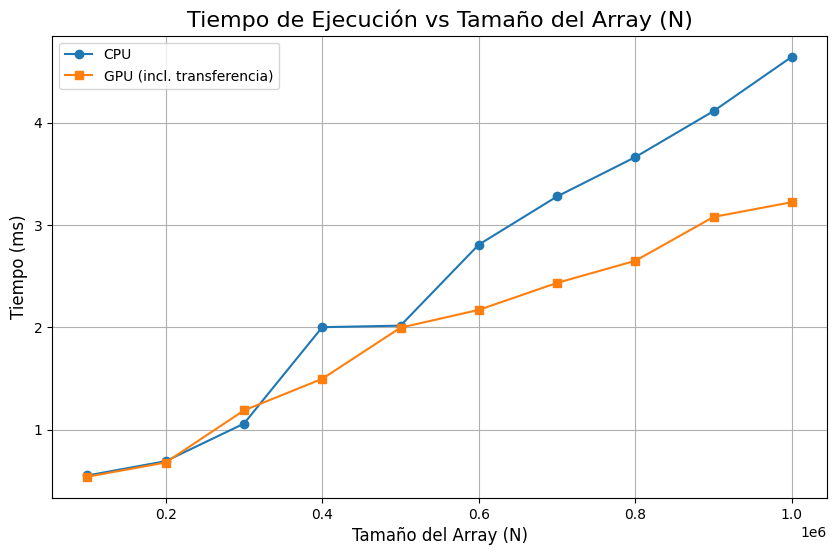

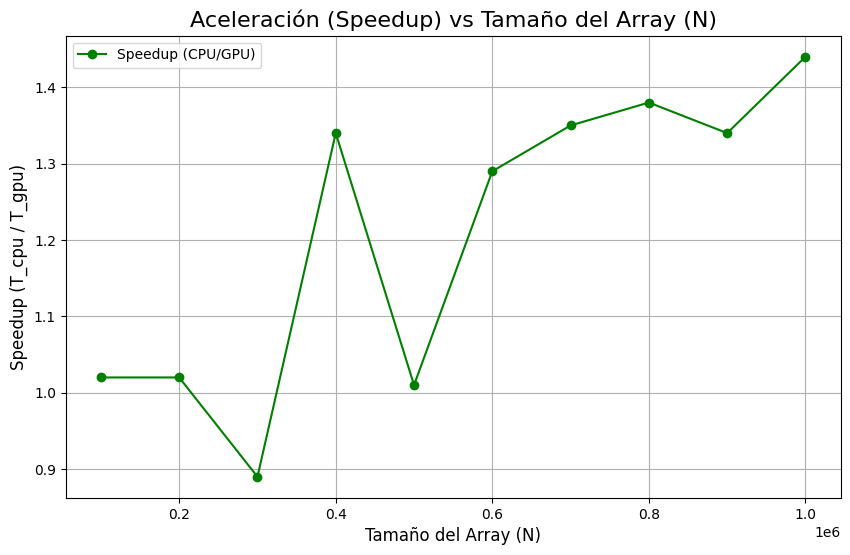

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import re

# Leer el archivo de resultados
with open('results.txt', 'r') as f:
    lines = f.readlines()

# Procesar las líneas para convertirlas a un formato CSV
data_lines = []
found_header = False
for line in lines:
    if '----' in line: # Empezar a leer después de la línea '----'
        found_header = True
        continue
    if found_header and line.strip():
        # Limpiar la línea: quitar ' | ', 'x', y espacios extra
        cleaned_line = re.sub(r'\s*\|\s*', ',', line.strip())
        cleaned_line = cleaned_line.replace('x', '')
        data_lines.append(cleaned_line)

# Crear un string CSV
csv_header = "N,CPU (ms),GPU (ms),Speedup"
csv_data = csv_header + '\n' + '\n'.join(data_lines)

# Cargar en un DataFrame de pandas
df = pd.read_csv(io.StringIO(csv_data))

print("Resultados cargados en el DataFrame:")
display(df)

# --- Gráfica 1: Tiempos de Ejecución  ---
plt.figure(figsize=(10, 6))
plt.plot(df['N'], df['CPU (ms)'], marker='o', label='CPU')
plt.plot(df['N'], df['GPU (ms)'], marker='s', label='GPU (incl. transferencia)')
plt.title('Tiempo de Ejecución vs Tamaño del Array (N)', fontsize=16)
plt.xlabel('Tamaño del Array (N)', fontsize=12)
plt.ylabel('Tiempo (ms)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('tiempos.png')
plt.show()

# --- Gráfica 2: Aceleración (Speedup)  ---
plt.figure(figsize=(10, 6))
plt.plot(df['N'], df['Speedup'], marker='o', label='Speedup (CPU/GPU)', color='green')
plt.title('Aceleración (Speedup) vs Tamaño del Array (N)', fontsize=16)
plt.xlabel('Tamaño del Array (N)', fontsize=12)
plt.ylabel('Speedup (T_cpu / T_gpu)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('speedup.png')
plt.show()

3. Análisis del TAMAÑO DE BLOQUE (BLOCK_SIZE)

**¿Qué TAMAÑO DE BLOQUE (número de hilos por bloque) has utilizado?**

En esta implementación se ha utilizado un `BLOCK_SIZE` de **256 hilos por bloque**.

**¿Crees que es lo óptimo? Explique los resultados.**

Determinar el `BLOCK_SIZE` *óptimo* es complejo y depende de la arquitectura específica de la GPU (por ejemplo, la Tesla T4 o V100 que asigne Colab), pero **256 es una elección robusta y frecuentemente cercana a la óptima** por las siguientes razones:

1.  **Utilización del Warp:** Las GPUs de Nvidia ejecutan hilos en grupos de 32, llamados *warps*. Un tamaño de bloque múltiplo de 32 (como 256, que son 8 warps) asegura que todos los warps estén llenos, maximizando la eficiencia de ejecución (SIMD).
2.  **Ocultación de Latencia:** El principal objetivo del paralelismo en CUDA es tener suficientes warps activos (residentes) en un Streaming Multiprocessor (SM) para "ocultar la latencia". Mientras un warp espera por datos de la memoria global (una operación lenta), el SM puede cambiar y ejecutar otro warp que esté listo. Un `BLOCK_SIZE` de 256 proporciona 8 warps por bloque, lo que ayuda a este propósito.
3.  **Equilibrio de Recursos:** El `BLOCK_SIZE` óptimo depende de los recursos que consume cada bloque (registros y memoria compartida).
    * [cite_start]**Memoria Compartida:** Nuestro kernel usa `(BLOCK_SIZE + 2 * RADIUS) * sizeof(int)` de memoria compartida[cite: 928]. Si `BLOCK_SIZE` fuera muy grande (ej. 1024), este consumo podría ser tan alto que solo uno o dos bloques cabrían en un SM, limitando el número total de warps activos y reduciendo la ocultación de latencia.
    * **Registros:** De manera similar, si el kernel usara muchos registros por hilo, un `BLOCK_SIZE` muy grande agotaría el banco de registros del SM.

**Conclusión:** 256 hilos es un "punto dulce" (*sweet spot*). No es tan pequeño como para no generar suficientes warps para ocultar la latencia, ni tan grande como para agotar los recursos del SM (memoria compartida o registros) y limitar la *ocupación* (*occupancy*). Es probable que valores como 128 o 512 ofrezcan un rendimiento similar, pero 256 es una elección inicial excelente y bien justificada.